# **Week 5: GANs Mini-Project**
***
## **Overview**

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

(Please refer to https://www.kaggle.com/competitions/gan-getting-started/overview for additional information about this dataset.)

***
## **Step 1 Brief Description**

### **1.1 Problem**

- **Challenge**: The goal of this challenge is to develop a **Generative Adversarial Network (GAN)** capable of generating between 7,000 to 10,000 Monet-style images. A GAN consists of two competing neural networks: a **generator** and a **discriminator**. The generator is responsible for creating Monet-style images, while the discriminator evaluates whether the generated images are real (from the original Monet dataset) or fake (produced by the generator). These two networks are trained in an adversarial manner—meaning the generator continuously improves to fool the discriminator, and the discriminator learns to better distinguish between real and generated images. The challenge lies in achieving a balance where the generator produces high-quality, realistic Monet-style artwork while ensuring the discriminator does not become too dominant and stifle the learning process.

- **GAN**: For this challenge, I have chosen to implement a **Deep Convolutional GAN (DCGAN)** as the generative model. DCGAN enhances traditional GANs by using convolutional and transposed convolutional layers to generate high-quality images. The **generator** takes random noise as input and upsamples it through convolutional layers with batch normalization and LeakyReLU activation to create Monet-style images. The **discriminator** analyzes input images using convolutional layers to distinguish between real Monet paintings and generated ones. DCGAN’s architectural improvements, such as convolutional layers and batch normalization, help stabilize training and produce visually coherent Monet-style paintings by capturing key artistic features like color tones, brushstrokes, and composition.

### **1.2 Data**

- **Dataset**:
  - `monet_jpg`: **Monet paintings** used for training to learn and generate Monet-style artworks.
  - `photo_jpg`: **Real-world photos** intended for style transfer tasks, not used in this project as DCGAN generates images from random noise instead of transforming existing photos.<br><br>

- **Size and Dimensions**:
    - **Number of images**: 300
    - **Image resolution**: 256 x 256 pixels
    - **File format**: JPEG
    - **Color Channels**: 3 (RGB)

***
## **Step 2 EDA**

### **2.1 Data Preparation**
- **Loading and Preprocessing the Dataset**: Using TensorFlow's Keras API to load images and apply essential preprocessing steps, including resizing, normalization, and batching, to prepare the data for model training.

In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set image size and batch size
IMG_SIZE = (256, 256)  # Image size
BATCH_SIZE = 16        # Batch size

# Set data path
MONET_PATH = '/kaggle/input/gan-getting-started/monet_jpg'

In [4]:
# Image preprocessing function
def load_and_preprocess_image(image_path):
    img = load_img(image_path.decode('utf-8'), target_size=IMG_SIZE)  # Load image
    img = img_to_array(img)  # Convert to array
    img = (img / 127.5) - 1  # Normalize to [-1, 1]
    return img.astype(np.float32)

In [5]:
# Get the list of image files
monet_images = np.array([os.path.join(MONET_PATH, f) for f in os.listdir(MONET_PATH)])

# Create TensorFlow Dataset
def create_dataset(image_list):
    dataset = tf.data.Dataset.from_tensor_slices(image_list)
    dataset = dataset.map(lambda x: tf.numpy_function(func=load_and_preprocess_image, inp=[x], Tout=tf.float32))
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create the dataset
monet_ds = create_dataset(monet_images)

# Have a look at the batch shape
for img_batch in monet_ds.take(1):
    print(f"Monet batch shape: {img_batch.shape}")

Monet batch shape: (16, 256, 256, 3)


***
### **2.2 Visualizations**
- **Monet Paintings**: Displaying four Monet paintings from the dataset to visually inspect the data quality and confirm proper preprocessing.

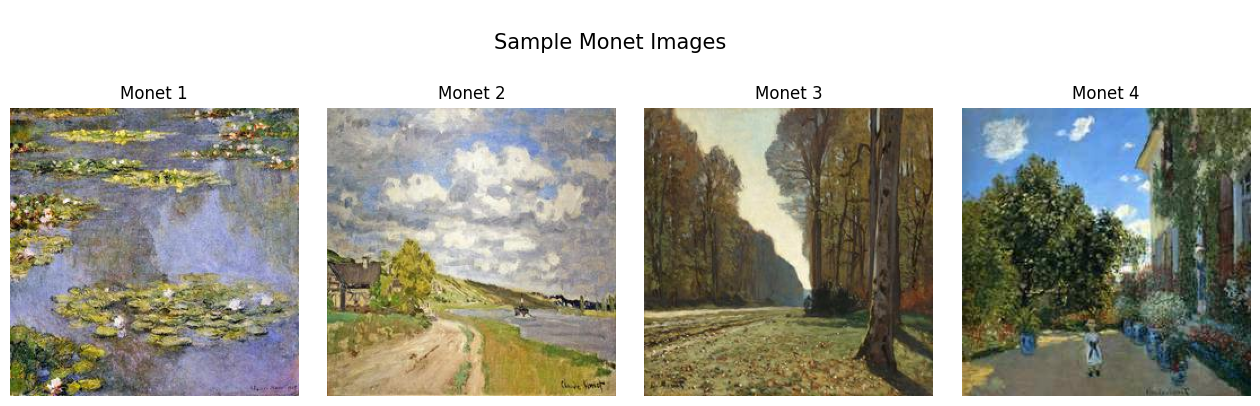

In [5]:
# Have a look at Monet paintings
plt.figure(figsize=(16, 4))

for i, image in enumerate(monet_ds.take(1)):  # Take one batch
    for j in range(4):  # Display the first 4 images
        plt.subplot(1, 4, j + 1)  # 1x4 grid display
        plt.imshow((image[j].numpy() + 1) / 2)  # Convert back to [0, 1] range for display
        plt.title(f"Monet {j+1}")
        plt.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.suptitle("\nSample Monet Images\n", fontsize=15, y=1.1)

plt.show()

***
- **Edge Detection**: Applying Canny edge detection to Monet paintings and visualizing the extracted edges to analyze the structural details and contours in grayscale.

In [24]:
import cv2

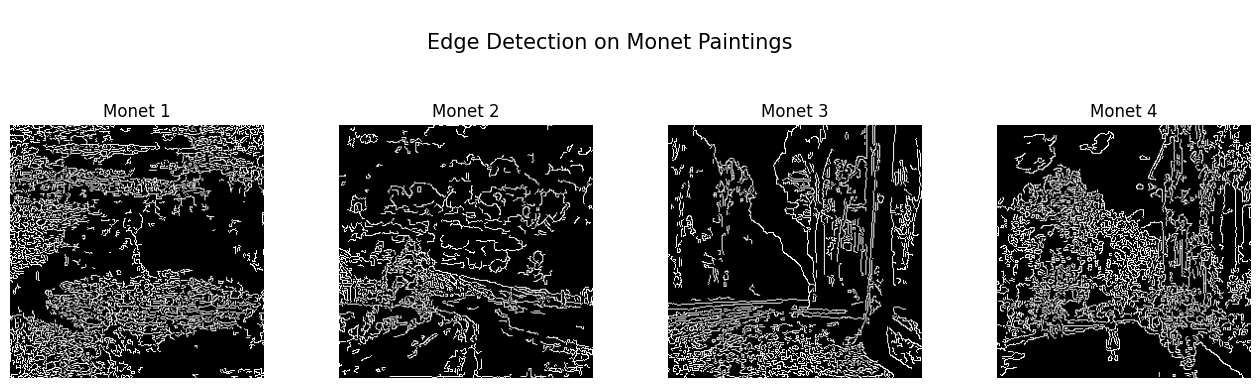

In [33]:
plt.figure(figsize=(16, 4))

for i, img_path in enumerate(monet_images[:4]):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    edges = cv2.Canny(img, 100, 200)  # Apply Canny edge detection

    plt.subplot(1, 4, i + 1)  # 1 row, 4 columns
    plt.imshow(edges, cmap='gray')
    plt.title(f"Monet {i+1}")
    plt.axis('off')

plt.suptitle("\nEdge Detection on Monet Paintings\n", fontsize=15, y=1.1)
plt.subplots_adjust(wspace=0.3)  # Adjust spacing between images
plt.show()

***
### **2.3 Checking for Duplicate**
- Counting the total and unique Monet paintings in the dataset to identify any duplicate images.

In [30]:
unique_images = len(set(monet_images))
total_images = len(monet_images)
print(f"Total images: {total_images}, Unique images: {unique_images}")
if unique_images < total_images:
    print("Warning: Duplicate images found.")

Total images: 300, Unique images: 300


***
## **Step 3 Model Building and Training**

### **3.1 Building: First DCGAN Model**
We will build a basic Deep Convolutional Generative Adversarial Network (DCGAN).

- **Step Overview**：
  
    - **Build the Generator**: The generator is responsible for transforming random noise (a latent vector) into Monet-style images. It consists of a series of transposed convolutional layers (also known as deconvolution layers) that progressively upsample the noise into a structured image. The generator aims to produce images that resemble real Monet paintings as closely as possible, learning the artistic style and color patterns.

    - **Build the Discriminator**: The discriminator acts as a binary classifier that distinguishes between real Monet paintings and artificially generated ones. It consists of convolutional layers that downsample the input image, extracting high-level features to assess authenticity. The discriminator’s goal is to correctly identify whether an image is real (from the Monet dataset) or fake (created by the generator), thereby providing feedback to improve the generator's performance over time.
 
Through the adversarial training process, the generator and discriminator are optimized simultaneously in a competitive setup, leading to the production of increasingly realistic Monet-style paintings.

#### **3.1.1 Generator**

- **Input Layer**: Takes a 1D random noise vector of size `latent_dim` (128).
  
- **Dense Layer**: Expands the noise vector to a feature map of size `16x16x512`.
  
- **Reshape Layer**: Converts the flattened vector into a 3D feature map (16x16x512).
  
- **Transposed Convolutions Layers (Upsampling)**:
  - 16x16 → 32x32 (256 filters)
  - 32x32 → 64x64 (128 filters)
  - 64x64 → 128x128 (64 filters)
  - 128x128 → 256x256 (3 output channels)<br><br>

- **Activation** and **Normalization**: Each transposed convolution is followed by `Batch Normalization` and `LeakyReLU` activation (except the final layer which uses `tanh` activation).

- **Output Layer**: Produces a final `256x256x3` image with pixel values normalized to the range [-1, 1]

In [6]:
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.models import Model

In [7]:
def build_generator(latent_dim):
    inputs = Input(shape=(latent_dim,))  # Receive random noise vector
    x = Dense(16 * 16 * 512, use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((16, 16, 512))(x)  # Reshape into 16x16x512 feature map

    x = Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)  # Upsample to 32x32
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)  # Upsample to 64x64
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)   # Upsample to 128x128
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Ensure output is 256x256x3, which is the final upsampling
    x = Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh")(x)  # Upsample to 256x256

    model = Model(inputs, x, name="generator")
    return model

latent_dim = 128  # Dimension of random noise
generator = build_generator(latent_dim)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 131072)              │      16,777,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 131072)              │         524,288 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 256)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 64)        │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 256, 256, 3)         │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,058,883 (76.52 MB)

 Trainable params: 19,795,843 (75.52 MB)

 Non-trainable params: 263,040 (1.00 MB)

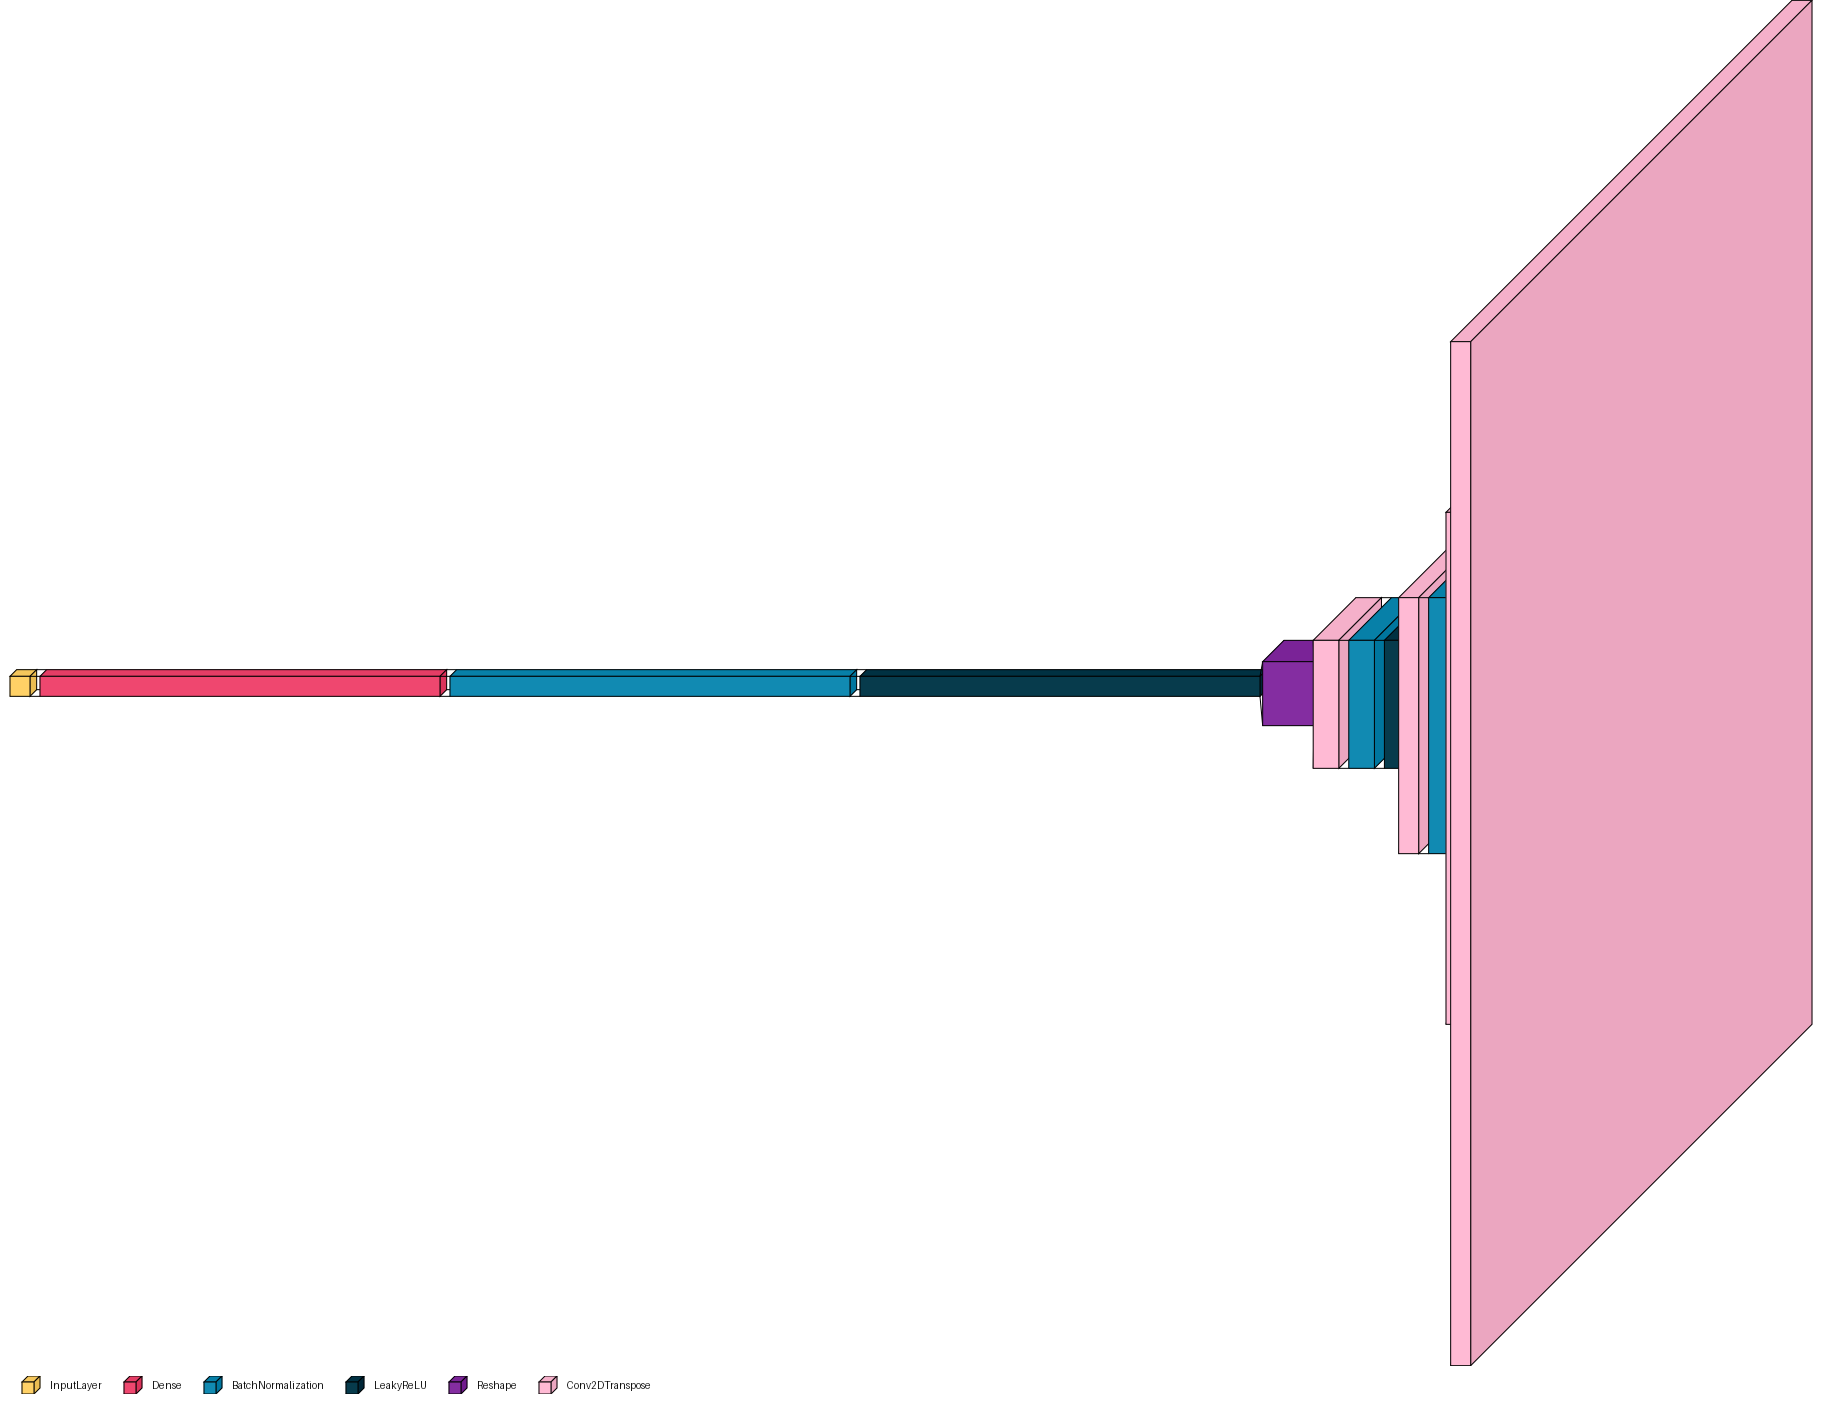

In [9]:
os.system('pip install visualkeras')
import visualkeras
visualkeras.layered_view(generator, legend=True)

#### **3.1.2 Discriminator**

- **Input Layer**: Takes an image of shape `(256, 256, 3)` (height, width, and RGB channels).
  
- **Convolutional Layers (Downsampling)**:
  - **1st Layer**: 64 filters, kernel size 4x4, stride 2 (output: 128x128x64).
  - **2nd Layer**: 128 filters, kernel size 4x4, stride 2 (output: 64x64x128).
  - **3rd Layer**: 256 filters, kernel size 4x4, stride 2 (output: 32x32x256).<br><br>

- **Activation** and **Regularization**:
  - **LeakyReLU Activation**: With an alpha of `0.2` to allow small negative values.
  - **Dropout Layer**: With a rate of `0.3 to` reduce overfitting by randomly deactivating neurons during training.

- **Flattening Layer**: Converts the final 3D feature map into a 1D vector for classification.

- **Output Layer**:A fully connected (`Dense`) layer with a single neuron using `sigmoid` activation, which outputs a probability score indicating whether the input image is real (close to 1) or fake (close to 0).

In [11]:
from tensorflow.keras.layers import Conv2D, Flatten, Dropout

In [12]:
def build_discriminator(img_shape):
    inputs = Input(shape=img_shape) # Input: 256x256x3 image

    x = Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)  # Downsamples to 128x128x64
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)  # Downsamples to 64x64x128
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding="same")(x) # Downsamples to 32x32x256
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x) # Flatten the feature maps to a 1D vector for classification
    x = Dense(1, activation="sigmoid")(x) # Output layer

    model = Model(inputs, x, name="discriminator")
    return model

discriminator = build_discriminator((256, 256, 3))
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         262,145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 921,025 (3.51 MB)

 Trainable params: 921,025 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

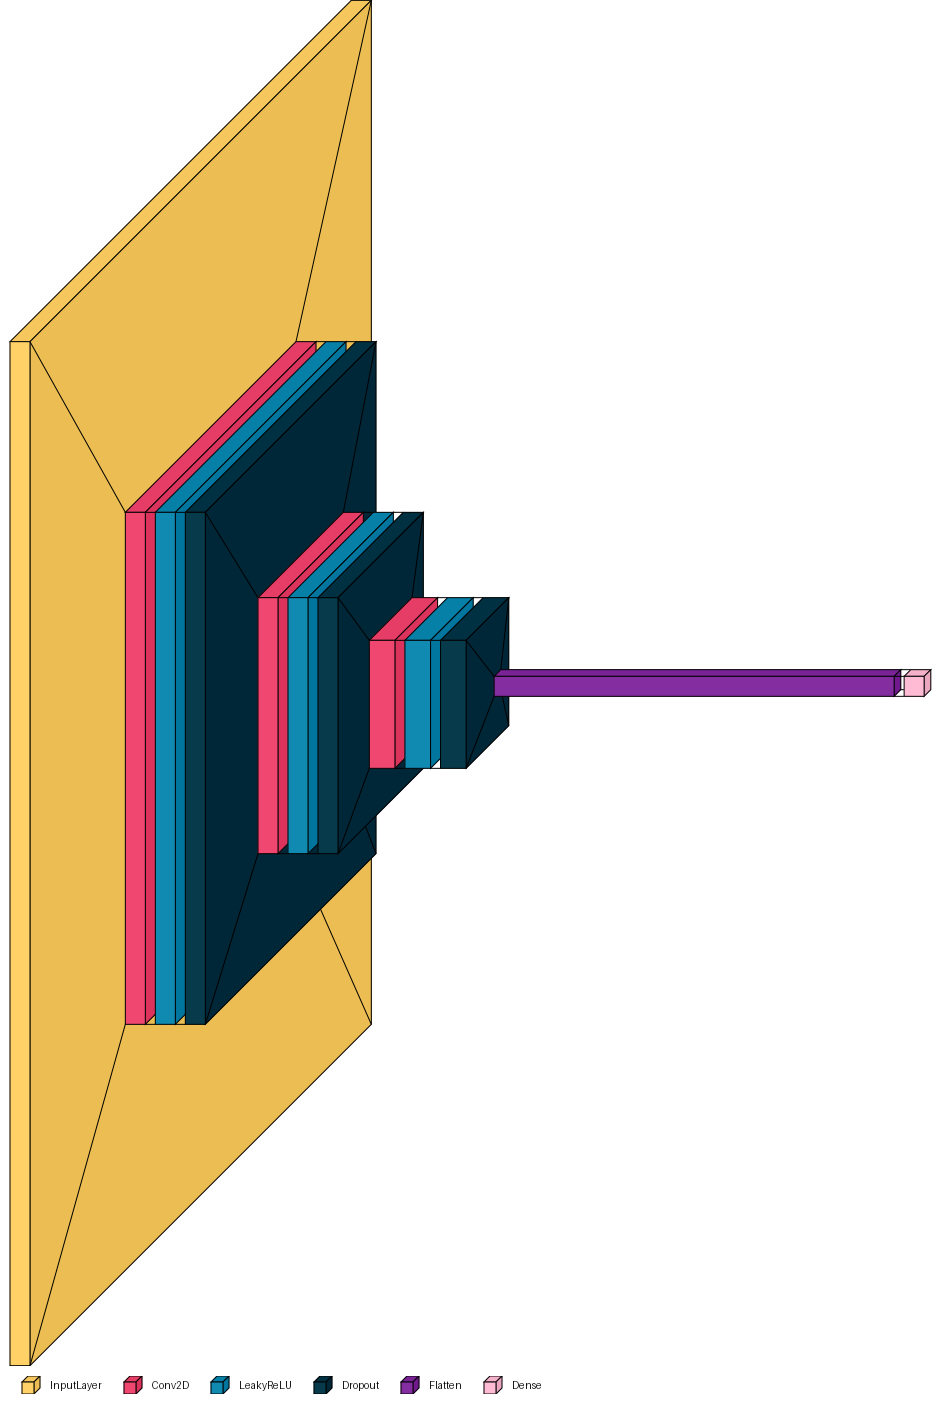

In [13]:
visualkeras.layered_view(discriminator, legend=True)

#### **3.1.3 Loss Function & Optimizers**

- **Loss Function**:
  - `BinaryCrossentropy` is used as the loss function to measure the accuracy of real vs. generated images.
  - It evaluates how well the discriminator distinguishes real from fake images by comparing predicted and actual labels.<br><br>

- **Optimizers**:
  - The **Adam optimizer** is chosen to optimize the weights of both the generator and discriminator.
  - A **learning rate** of `0.0002` ensures gradual updates for stable learning.
  - `beta_1=0.5` is used to reduce oscillations and improve convergence stability.

In [10]:
# Define the loss function for the generator and discriminator
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Optimizer for the generator
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Optimizer for the discriminator
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

#### **3.1.4 Training**

The training process involves iterating over the dataset for a specified number of epochs. In each step, random noise is fed into the generator to produce fake images, which are then evaluated by the discriminator alongside real images. The generator is optimized to produce images that the discriminator classifies as real, while the discriminator is trained to distinguish real from fake images accurately. Gradients are computed and applied to update the weights of both models. Throughout training, the generator and discriminator losses are recorded and displayed, helping to monitor the progress and performance of the DCGAN.

In [11]:
# Record losses
gen_losses = []
disc_losses = []

# Define a single training step, using @tf.function to optimize execution speed
@tf.function
def train_step(real_images):
    # Generate random noise as input to the generator
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    # Track gradients
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Use the generator to create fake images
        generated_images = generator(noise, training=True)

        # Discriminator's output for real images
        real_output = discriminator(real_images, training=True)
        
        # Discriminator's output for fake (generated) images
        fake_output = discriminator(generated_images, training=True)

        # Compute generator loss
        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)
        
        # Compute discriminator loss
        disc_loss_real = loss_fn(tf.ones_like(real_output), real_output)
        disc_loss_fake = loss_fn(tf.zeros_like(fake_output), fake_output)
        disc_loss = disc_loss_real + disc_loss_fake

    # Calculate gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Use optimizers to update the weights of the generator and discriminator
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Define the overall training process
def train(dataset, epochs=50):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())

        print(f"Epoch {epoch+1}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")


# Start training, running for 50 epochs
train(monet_ds, epochs=50)

Epoch 1, Generator Loss: 6.0504, Discriminator Loss: 0.0599
Epoch 2, Generator Loss: 4.1659, Discriminator Loss: 0.0311
Epoch 3, Generator Loss: 2.4785, Discriminator Loss: 0.0893
Epoch 4, Generator Loss: 2.3366, Discriminator Loss: 0.1025
Epoch 5, Generator Loss: 3.0087, Discriminator Loss: 0.0511
Epoch 6, Generator Loss: 25.6728, Discriminator Loss: 0.9115
Epoch 7, Generator Loss: 3.2392, Discriminator Loss: 2.2481
Epoch 8, Generator Loss: 1.3261, Discriminator Loss: 1.6336
Epoch 9, Generator Loss: 1.1974, Discriminator Loss: 1.2369
Epoch 10, Generator Loss: 1.7158, Discriminator Loss: 0.9075
Epoch 11, Generator Loss: 2.6453, Discriminator Loss: 2.0893
Epoch 12, Generator Loss: 1.5582, Discriminator Loss: 0.8547
Epoch 13, Generator Loss: 1.1762, Discriminator Loss: 1.1354
Epoch 14, Generator Loss: 1.2316, Discriminator Loss: 1.2743
Epoch 15, Generator Loss: 1.0310, Discriminator Loss: 1.0734
Epoch 16, Generator Loss: 0.9658, Discriminator Loss: 1.1265
Epoch 17, Generator Loss: 1.3326

#### **3.1.5 Visualize Results**

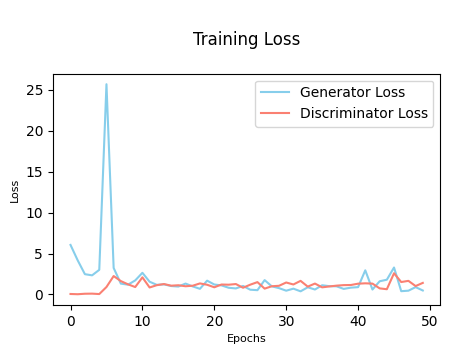

In [12]:
# Visualize loss
plt.figure(figsize=(5, 3))
plt.plot(gen_losses, label='Generator Loss', color='skyblue')
plt.plot(disc_losses, label='Discriminator Loss', color='salmon')
plt.xlabel('Epochs', fontsize=8)
plt.ylabel('Loss', fontsize=8)
plt.title('\nTraining Loss\n', fontsize=12)
plt.legend()
plt.show()

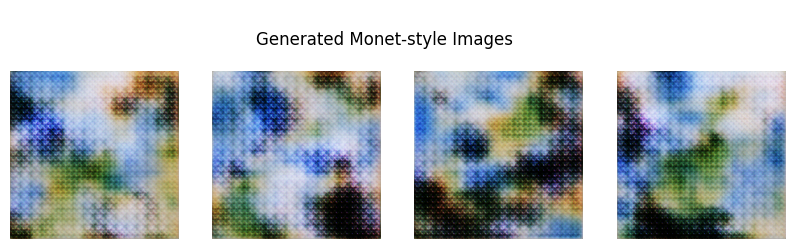

In [13]:
# Generate and display images
def generate_and_show_images(generator, num_images=4):
    noise = tf.random.normal([num_images, latent_dim]) # Generate random noise as input
    generated_images = generator(noise, training=False) # Generate images using the generator

    plt.figure(figsize=(10, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow((generated_images[i].numpy() + 1) / 2)  # Convert back to [0,1] range for display
        plt.axis('off')
    plt.suptitle("\nGenerated Monet-style Images\n", fontsize=12)
    plt.show()

generate_and_show_images(generator)

***
### **3.2 Hyperparameter Tuning: Second DCGAN Model**<br><br>

- **Training Duration**: Increase the number of `epochs` from 50 to **200** to allow for more thorough training and better convergence.
  
- **Learning Rate**: Reduce the **generator's** `learning rate` to **0.0001** to balance training dynamics and prevent the discriminator from overpowering the generator.

- **Momentum**: Adjust the `beta_1` parameter to **0.4** to stabilize training and improve the Adam optimizer’s momentum behavior.

- **Label Smoothing**: Implement label smoothing, replacing the real label value of 1 with a random value between **0.9 and 1.0**, to enhance stability and prevent overfitting.

- **Training Frequency**: Train the **generator** **twice per batch** to help reduce mode collapse and improve the diversity of generated images.

#### **3.2.1 Loss Function & Optimizers**

In [14]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.4)

#### **3.2.2 Training**

In [15]:
gen_losses = []
disc_losses = []

@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Label Smoothing: Replace real label 1 with 0.9, keeping fake label as 0
        real_labels = tf.random.uniform(shape=tf.shape(real_output), minval=0.9, maxval=1.0)  # Smoothed positive labels
        fake_labels = tf.zeros_like(fake_output)  # Fake labels remain 0
        
        # Compute losses
        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)  # Generator tries to create real-looking images
        disc_loss_real = loss_fn(real_labels, real_output)  # Using smoothed positive labels
        disc_loss_fake = loss_fn(fake_labels, fake_output)  # Fake labels remain 0
        disc_loss = disc_loss_real + disc_loss_fake

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs=200):
    for epoch in range(epochs):
        for image_batch in dataset:
            for _ in range(2):  # Train the generator twice
                gen_loss, disc_loss = train_step(image_batch)

        gen_losses.append(gen_loss.numpy())
        disc_losses.append(disc_loss.numpy())

        print(f"Epoch {epoch+1}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")


# Start training, running for 200 epochs
train(monet_ds, epochs=200)

Epoch 1, Generator Loss: 0.6827, Discriminator Loss: 0.9757
Epoch 2, Generator Loss: 0.6623, Discriminator Loss: 1.0363
Epoch 3, Generator Loss: 1.4577, Discriminator Loss: 0.5377
Epoch 4, Generator Loss: 0.2031, Discriminator Loss: 2.1459
Epoch 5, Generator Loss: 1.3261, Discriminator Loss: 0.6248
Epoch 6, Generator Loss: 2.4488, Discriminator Loss: 0.3542
Epoch 7, Generator Loss: 1.6655, Discriminator Loss: 0.4439
Epoch 8, Generator Loss: 1.8324, Discriminator Loss: 0.4815
Epoch 9, Generator Loss: 2.2200, Discriminator Loss: 0.4212
Epoch 10, Generator Loss: 0.1651, Discriminator Loss: 2.4482
Epoch 11, Generator Loss: 2.7721, Discriminator Loss: 0.3297
Epoch 12, Generator Loss: 2.0771, Discriminator Loss: 0.4515
Epoch 13, Generator Loss: 2.1134, Discriminator Loss: 0.4365
Epoch 14, Generator Loss: 1.0840, Discriminator Loss: 0.7255
Epoch 15, Generator Loss: 1.8505, Discriminator Loss: 0.4670
Epoch 16, Generator Loss: 1.0408, Discriminator Loss: 0.7201
Epoch 17, Generator Loss: 1.7154,

#### **3.2.3 Visualize Results**

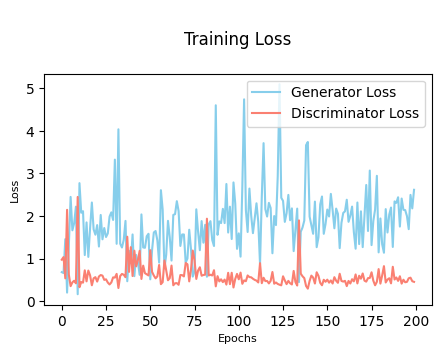

In [16]:
# Visualize loss 
plt.figure(figsize=(5, 3))
plt.plot(gen_losses, label='Generator Loss', color='skyblue')
plt.plot(disc_losses, label='Discriminator Loss', color='salmon')
plt.xlabel('Epochs', fontsize=8)
plt.ylabel('Loss', fontsize=8)
plt.title('\nTraining Loss\n', fontsize=12)
plt.legend()
plt.show()

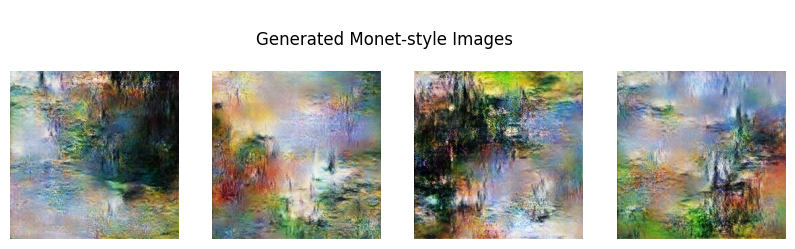

In [17]:
# Generate and display images
def generate_and_show_images(generator, num_images=4):
    noise = tf.random.normal([num_images, latent_dim])
    generated_images = generator(noise, training=False)

    plt.figure(figsize=(10, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow((generated_images[i].numpy() + 1) / 2)
        plt.axis('off')
    plt.suptitle("\nGenerated Monet-style Images\n", fontsize=12)
    plt.show()

generate_and_show_images(generator)

***
### **3.3 Submit Images**

- Generate **7,000** Monet-style images using the **generator**.

- Save the images as **JPG files** in the output directory.

- **Compress the images** into a ZIP archive.

- **Clean up temporary files** by removing the generated image folder.

- **Final output** consists of the **ZIP file** containing all the generated images.

In [21]:
from tensorflow.keras.preprocessing.image import array_to_img
import zipfile
import shutil

In [22]:
# Define paths
output_dir = "/kaggle/working/generated_images"
zip_file_path = "/kaggle/working/images.zip"

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Number of images to generate
num_images = 7000
latent_dim = 128

# Function to generate images without printing progress
def generate_and_save_images(generator, num_images, output_dir):
    for i in range(num_images):
        noise = tf.random.normal([1, latent_dim])  # Generate random noise
        generated_image = generator(noise, training=False)  # Generate image
        
        # Convert from [-1, 1] to [0, 255]
        img = (generated_image[0].numpy() + 1) * 127.5
        img = img.astype(np.uint8)

        # Save image as JPG
        img_path = os.path.join(output_dir, f"monet_{i+1}.jpg")
        array_to_img(img).save(img_path)

    print("All images generated successfully.")

# Generate and save images
generate_and_save_images(generator, num_images, output_dir)

# Compress images to a zip file without printing progress
def zip_images(output_dir, zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'w') as zipf:
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                zipf.write(os.path.join(root, file), arcname=file)

# Create ZIP archive
zip_images(output_dir, zip_file_path)

# Clean up by removing the generated images folder
shutil.rmtree(output_dir)

print("Image generation and compression complete. The only output is 'images.zip'.")

All images generated successfully.
Image generation and compression complete. The only output is 'images.zip'.


![score](score.jpg)

***
## **Step 4 Results and Analysis**

### **4.1 Visualization Analysis**

- **Loss Trend**:
  
  - **DCGAN 1 (epochs=50)**: The training loss analysis over 50 epochs shows that the generator initially struggled, with a significant spike at **epoch 6**, but both generator and discriminator losses **gradually stabilized** afterward, indicating improved balance. The generator loss fluctuated but did not collapse to zero, suggesting that mode collapse was likely avoided, while the discriminator maintained a loss around 1, meaning it remained effective in distinguishing real from fake images. By epoch 50, the generator loss decreased to **0.4863**, and the discriminator loss was **1.4144**, showing a slight advantage for the discriminator. The **mean generator loss of 1.9031** indicates ongoing learning, but further improvements are needed to produce more realistic images. A **mean discriminator loss of 1.1156** suggests balanced competition, as values around **1.0** are ideal for training stability. To optimize performance, fine-tuning learning rates and training frequency may be required. Overall, the training is progressing well, but further refinements and qualitative evaluations are needed to ensure high-quality results.
    
  - **DCGAN 2 (epochs=200)**: The training loss analysis over 200 epochs indicates that the generator loss fluctuated, with several peaks and valleys, suggesting challenges in learning but overall improvement. The **mean generator loss of 1.8341** shows that the generator is performing better compared to earlier stages, but still requires further optimization to generate high-quality images consistently. Meanwhile, the **discriminator loss averaged at 0.7039**, indicating that it is becoming increasingly confident in distinguishing real from generated images, which might lead to challenges for the generator in future training. The training process shows that while the generator continues to learn, the discriminator is becoming too strong, which could hinder generator performance. A lower generator loss is ideal, but if the discriminator loss drops too much, it may indicate that it is overpowering the generator. Overall, the model shows promising progress, but maintaining an optimal balance between the two networks remains crucial to achieving high-quality results.<br><br>
 
<div style="text-align: center;">

| DCGAN 1              | DCGAN 2              |
|---------------------|---------------------|
| <img src="model1.jpg" width="400"> | <img src="model2.jpg" width="400"> |

</div>

- **Images Quality**:
  
  - **DCGAN 1 (epochs=50)**:
 
    - **Lack of Details**: The images are **blurry**, indicating the generator hasn't yet learned Monet's fine-grained features. More training is needed to capture intricate textures.
  
    - **Color Distribution**: While the colors resemble Monet’s style, they are **overly blended** without clear separation, requiring further refinement for better contrast and realism.
   
    - **Repetitive Patterns**: **Grid-like artifacts** suggest issues such as insufficient data variation, architectural limitations, or imbalanced loss between the generator and discriminator.
   
    - **Mode Collapse**: The images appear **similar**, indicating mode collapse, where the generator lacks diversity. More training and learning rate adjustments could help.<br><br>
   
  - **DCGAN 2 (epochs=200)**:
 
    - **Improved Details**: The images now have **finer textures** and **better-defined elements**, though some areas remain **blurry**, requiring further training.
      
    - **Better Color Distribution**: Colors are more **vibrant** and **well-separated**, capturing Monet’s style more effectively, but some areas are still **overly smooth**.
   
    - **Reduced Artifacts**: The earlier grid-like artifacts are largely gone, with more **natural patterns**, though occasional inconsistencies remain.
   
    - **Increased Diversity**: The outputs show **greater variation**, reducing mode collapse, but further structural refinement is needed.<br><br>

<div align="center">

| DCGAN 1              | DCGAN 2              |
|---------------------|---------------------|
| <img src="ep50.jpg" width="500"> | <img src="ep200.jpg" width="500"> |

</div>

***
### **4.2 Comparison Table**

| Model   | Epoch | Generator Mean Loss | Discriminator Mean Loss | Generated Image               |
|:-------:|:-----:|:------------------:|:-----------------------:|:-----------------------------:|
| DCGAN 1 |  50   |       1.9031        |          1.1156         | <img src="ep50.jpg" width="400"> |
| DCGAN 2 | 200   |       1.8341        |          0.7039         | <img src="ep200.jpg" width="400"> |

***
## **Step 5 Conclusion**

#### **5.1 Takeaways**

- **DCGAN 2 performed better**, producing images that are closer to real Monet-style paintings.

- A **lower generator loss** in DCGAN 2 indicates improved image quality, while a **lower discriminator loss** suggests it became better at distinguishing fake from real images.

- Longer training (200 epochs) resulted in **smoother textures, better color distribution, and reduced artifacts**, compared to the 50-epoch model.

#### **5.2 Improvements**

- **What Helped**: Increasing the training epochs to **200** helped the generator capture finer details and better color variations, leading to improved image quality. The balanced losses ensured **better convergence** and **diverse outputs**, while fine-tuning hyperparameters like the **learning rate** and **batch size** made training more stable.


- **What Did Not Help**: Training for only **50 epochs** was insufficient for learning complex features, leading to blurry and repetitive patterns. The low discriminator loss in DCGAN 2 suggests the generator may struggle against an overly confident discriminator, and remaining artifacts indicate a need for further architecture optimization to enhance texture realism.


- **Suggestions for Improvement**: Extending training to **more than 200 epochs**, adjusting the **learning rate scheduling**, using **data augmentation**, and applying **regularization techniques** like dropout can further improve image quality and model generalization.

Overall, DCGAN 2 demonstrated significant improvements over DCGAN 1, producing images that are closer to real Monet-style paintings. However, further fine-tuning and longer training may be necessary to achieve even higher realism and diversity in generated outputs. Balancing the generator and discriminator through careful parameter adjustments will be key to achieving optimal results.

**GitHub Repository Link**

https://github.com/d93xup60126/GAN_Monet_Paintings
***